# Learning the lagrangian with rbf kernel

### importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn
from scipy.optimize import minimize
from scipy.optimize import approx_fprime

### Simple pendulum 

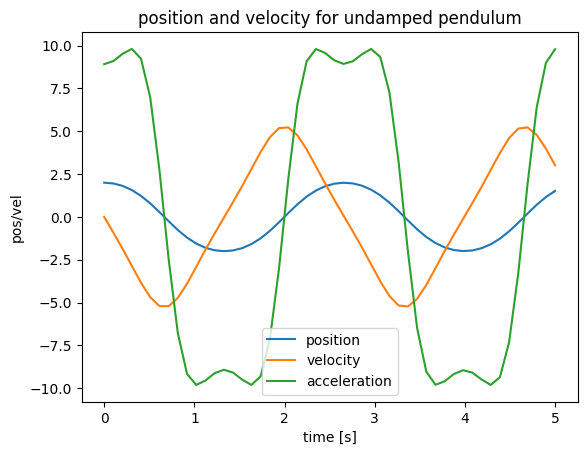

In [8]:
g = 9.81
l = 1
time_span = np.linspace(0, 5, 50)
h = time_span[1] - time_span[0]
init_state = (2, 0)
def pendulum(t, theta):
    theta_ddot = - (g/l) * np.sin(theta[0])
    return [theta[1], theta_ddot]
    
sol = solve_ivp(pendulum, (0, 5), init_state, t_eval= time_span)
q, qdot = sol.y 
t = sol.t
qddot = (g/l) * np.sin(q)


plt.plot(t, q, label = "position")
plt.plot(t, qdot, label = "velocity")
plt.plot(t, qddot, label = "acceleration")
plt.xlabel("time [s]")
plt.ylabel("pos/vel")
plt.title("position and velocity for undamped pendulum")
plt.legend()
plt.show()


### Discretizing the dataset with noise

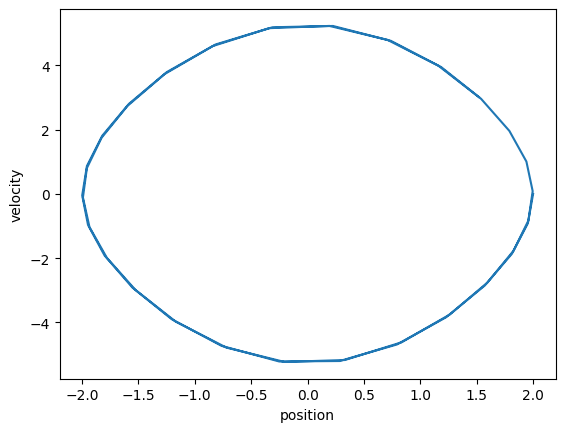

In [3]:
gaussian_noise = np.random.normal(0, 0.0, len(q))
q = q + gaussian_noise
qdot = qdot + gaussian_noise

input_data = np.column_stack((q, qdot))

def create_trajectories(q):
    trajectories = []
    for i in range(len(q) - 2):
        trajectories.append((q[i], q[i + 1], q[i + 2]))
    return np.array(trajectories)

trajectories = create_trajectories(q)
plt.plot(q, qdot)
plt.xlabel("position")
plt.ylabel("velocity")
plt.show()

### Defining guass kernel and gram matrix

In [4]:
sigma = 1
def compute_mass_matrix(q, dq, alpha, input_data):
    _, dL_ddq = lagrangian_derivatives(q, dq, alpha, input_data)
    return dL_ddq  # Second derivative of L with respect to dq
    
def positive_definite_penalty(alpha, input_data):
    penalty = 0
    for dp in input_data:
        q, dq = dp
        mass_matrix = compute_mass_matrix(q, dq, alpha, input_data)
        if mass_matrix <= 0:  # If eigenvalue is non-positive
            penalty += np.abs(mass_matrix)  # Penalize negative values
    return penalty

def rbfkernel(x, y, sigma):
    k = np.exp(-(np.linalg.norm(x - y)**2) / (2 * sigma**2))
    return k

def kernel_derivatives(q, dq, dp, sigma):
    diff = q - dp[0]
    diff_dq = dq - dp[1]
    base_kernel = rbfkernel(np.array([q, dq]), dp, sigma)

    d_k_dq = -diff / sigma**2 * base_kernel
    d_k_ddq = -diff_dq / sigma**2 * base_kernel

    return d_k_dq, d_k_ddq

def evaluate_lagrangian(q, dq, alpha, input_data):
    state = np.array([q, dq])
    kernels = np.array([rbfkernel(state, dp, sigma) for dp in input_data])
    return np.dot(alpha, kernels)

def lagrangian_derivatives(q, dq, alpha, input_data):
    dL_dq = 0
    dL_ddq = 0
    for i, dp in enumerate(input_data):
        d_k_dq, d_k_ddq = kernel_derivatives(q, dq, dp, sigma)
        dL_dq += alpha[i] * d_k_dq
        dL_ddq += alpha[i] * d_k_ddq
    return dL_dq, dL_ddq

def compute_acceleration(q, dq, alpha, input_data):
    dL_dq, dL_ddq = lagrangian_derivatives(q, dq, alpha, input_data)
    epsilon = 1e-6
    return -dL_dq / (dL_ddq + epsilon)

def pendulum_dynamics(t, y, alpha, input_data):
    q, dq = y
    ddq = compute_acceleration(q, dq, alpha, input_data)
    return [dq, ddq]

def discrete_lagrangian(q1, q2, h, alpha, input_data):
    q_mid = (q1 + q2) / 2
    dq = (q2 - q1) / h
    return h * evaluate_lagrangian(q_mid, dq, alpha, input_data)

def del_residual(q1, q2, q3, h, alpha, input_data):
    Ld1 = discrete_lagrangian(q1, q2, h, alpha, input_data)
    Ld2 = discrete_lagrangian(q2, q3, h, alpha, input_data)

    dL_dq2, _ = lagrangian_derivatives((q1 + q2) / 2, (q2 - q1) / h, alpha, input_data)
    dL_dq3, _ = lagrangian_derivatives((q2 + q3) / 2, (q3 - q2) / h, alpha, input_data)

    return np.linalg.norm(dL_dq2 + dL_dq3)**2

def loss_function(alpha, trajectories, h, input_data, lam=1e-5, pd_penalty=1e-3):
    loss = 0
    for q1, q2, q3 in trajectories:
        loss += del_residual(q1, q2, q3, h, alpha, input_data)
    
    # Regularization term
    loss += lam * np.sum(alpha**2)
    
    # Positive definite penalty
    loss += pd_penalty * positive_definite_penalty(alpha, input_data)
    return loss


# Generate input data
init_state = [2, 0]

def pendulum(t, theta):
    g = 9.81
    l = 1
    theta_ddot = -(g / l) * np.sin(theta[0])
    return [theta[1], theta_ddot]
iteration_counter = 0

def callback(alpha):
    global iteration_counter
    iteration_counter += 1
    print(f"Iteration {iteration_counter}: Current alpha = {alpha[:5]} (showing first 5 values)")

# Optimize alpha
alpha_init = np.random.randn(len(input_data)) * 1e2
result = minimize(
    loss_function,
    alpha_init,
    args=(trajectories, h, input_data, 1e-5),
    method='CG',
    options= {'disp': True, 'maxiter': 20},
    callback=callback
)

Iteration 1: Current alpha = [ -60.75361363   36.56004385 -152.94462065  -91.64855868 -135.7845568 ] (showing first 5 values)
Iteration 2: Current alpha = [ -61.66553853   35.9076957  -150.82181774  -88.01072237 -133.01478997] (showing first 5 values)
Iteration 3: Current alpha = [ -78.03269492   26.37205655 -104.55582273  -14.06741574 -117.64375596] (showing first 5 values)
Iteration 4: Current alpha = [ -80.66215289   25.79162204  -93.00808954   -3.2380019  -124.78331812] (showing first 5 values)
Iteration 5: Current alpha = [ -86.93851404   24.63865232  -63.86659382   22.78700863 -147.68216332] (showing first 5 values)
Iteration 6: Current alpha = [ -87.04952349   24.45501789  -63.49840051   23.40367974 -147.49360069] (showing first 5 values)
Iteration 7: Current alpha = [ -88.24972716   17.21602217  -64.66977551   29.91301958 -145.79695411] (showing first 5 values)
Iteration 8: Current alpha = [ -88.21353331    9.50293671  -67.54779085   29.32865    -155.12408719] (showing first 5 

C:\Users\emila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minimize.py:706: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


In [16]:
# Parameters from optimized alphas
print(result.x)

[ -86.63784819   -1.12016901  -67.50119793   43.43702376 -160.01752863
  -85.96302911 -152.34141311  -92.2780928     6.05823387  -83.07712564
   30.00967859  -27.17697565   30.20513505 -151.14152476    5.91224336
  -16.94080014   16.82530816   41.33765058  -25.56845775  -87.1128107
   78.47136864 -137.15959028   -9.54406903   -5.66261564  -47.12960143
   82.8959299   -28.81920881  -10.65728801  -11.12465065   10.07866559
   23.34418395  197.66733825   44.88988789  130.16983996   24.1687296
   -9.4885889    46.8975672  -124.11662866   56.93880335   -8.42319356
  -22.8174216    67.89935845 -101.44839603    0.38074441  -10.21385153
   59.95501261    8.83787655   40.61672107   63.71963055  -28.18915304]


# Formulas for Learning Dynamics with Gaussian Kernel Methods

This section outlines the key formulas used in the process of learning the dynamics of a simple pendulum.

---

## 1. Equations of Motion for the Pendulum

The pendulum's dynamics are described by:
$$
\ddot{\theta} = -\frac{g}{l} \sin(\theta)
$$
Rewritten as a system of first-order equations:
$$
\dot{\theta} = v, \quad \dot{v} = -\frac{g}{l} \sin(\theta)
$$

---

## 2. Gaussian Kernel

$$
K(x_i, x_j) = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)
$$

---

## 3. Gram Matrix

The Gram matrix is a matrix of kernel evaluations for all pairs of data points:
$$
K_{ij} = K((\theta_i, \dot{\theta}_i), (\theta_j, \dot{\theta}_j))
$$

---

## 4. Partial Derivatives of the Lagrangian

The partial derivatives of the Lagrangian L with respect to $\theta_i$  and $\dot{\theta}_i$  are computed as:
$$
\frac{\partial L}{\partial \theta_i} = \sum_{j=1}^N \alpha_j \cdot \left(-\frac{\theta_i - \theta_j}{\sigma^2}\right) \cdot K_{ij}
$$
$$
\frac{\partial L}{\partial \dot{\theta}_i} = \sum_{j=1}^N \alpha_j \cdot \left(-\frac{\dot{\theta}_i - \dot{\theta}_j}{\sigma^2}\right) \cdot K_{ij}
$$

---

## 5. Euler-Lagrange Equation

The acceleration $\ddot{\theta}_i$ is derived using the Euler-Lagrange equation:
$$
\ddot{\theta}_i = -\frac{\frac{\partial L}{\partial \theta_i}}{\frac{\partial L}{\partial \dot{\theta}_i}}
$$

---

## 6. Loss Function

The loss function minimizes the error between observed accelerations $\ddot{\theta}_i$ and predicted accelerations:
$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \left(\ddot{\theta}_i + \frac{\frac{\partial L}{\partial \theta_i}}{\frac{\partial L}{\partial \dot{\theta}_i} + \epsilon}\right)^2
$$
where \(\epsilon\) is a small regularization term to prevent division by zero.

---

## 7. Optimization of Dual Coefficients

The dual coefficients $\alpha$ are optimized by solving:
$$
\alpha = \text{argmin}_\alpha \mathcal{L}
$$
